In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
from termcolor import colored
import numpy as np
import os, errno
import pandas as pd
import matplotlib.pyplot as plt
from natsort import natsorted

In [3]:
# Display pandas df without truncation
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
# Globally setting font sizes via rcParams should be done with 

params = {
    'font.size': 11,
    'figure.figsize': (15,5),
    'figure.dpi': 40,
    'savefig.dpi': 300,
    'legend.fontsize': 11,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'axes.labelsize': 11,
    'axes.axisbelow': True
         }
plt.rcParams.update(params)


# The defaults can be restored using
# plt.rcParams.update(plt.rcParamsDefault)

In [5]:
main_folder = os.getcwd() #WARNING pycharm scprits not in the same dir
folder_experiments = 'results/MAR_2022_20#robots_rho#0.9/pkl_pos'

In [6]:
print(main_folder)

/home/luigi/Documents/ARGoS/argos-LMCRW-script


In [7]:
windows = np.array([1, 2, 3, 4, 5, 6, 9, 10, 12, 15, 18, 20, 30, 45, 60])

In [8]:
main_folder = os.getcwd() #attenzione pycharm scprits not in the same dir

baseline_folder = 'results/ALL/pos_pkl/Simulated/baseline'
simpleExperiment_folder = 'results/ALL/pos_pkl/Simulated/simple_experiment_100_runs'
biasExperiment_folder = 'results/ALL/pos_pkl/Simulated/bias_experiment_100_runs'
randomAngle_folder = 'results/ALL/pos_pkl/Simulated/random_angle_100_runs'
bouncingAngle_folder = 'results/ALL/pos_pkl/Simulated/bouncing_angle_100_runs'

windows = np.array([1, 2, 3, 4, 5, 6, 9, 10, 12, 15, 18, 20, 30, 45, 60])


### Fixed alpha

In [9]:
def evaluate_MSD(main_folder, folder_experiments, real_exp = False):
    msd_dict = {}
    windows = np.array([1, 2, 3, 4, 5, 6, 9, 10, 12, 15, 18, 20, 30, 45, 60])
    
    for dirName, subdirList, fileList in os.walk(os.path.join(main_folder, folder_experiments)):
        print(colored("DirName:", 'blue'), dirName)
        num_robots = -1
        alpha = -1
        rho = -1
        for fileName in natsorted(fileList):
            if 'real' in fileName:
                exp_type = 'real'
                if real_exp == False:
                    continue
            else:
                exp_type = 'simulated'
                if real_exp == True:
                    continue

            print(colored("\tfileName:", 'blue'), fileName)
            elements = fileName.split('_')
            for e in elements:
                if e.startswith('robots'):
                    num_robots = int(e.split('#')[1])
                if e.startswith('alpha'):
                    alpha = e.split('#')[1]
                if e.startswith('rho'):
                    rho = e.split('#')[1]

            if num_robots == -1:
                print('Error!!! num_robots not a right value')
                exit(-1)

            if alpha == -1:
                print('Error!!! num_robots not a right value')
                exit(-1)

            if rho == -1:
                print('Error!!! num_robots not a right value')
                exit(-1)

            if num_robots not in msd_dict:
                msd_dict[num_robots] = {}
            if alpha not in msd_dict[num_robots]:
                msd_dict[num_robots][alpha] = {}

            print('\tnum_robots: {}, alpha: {}, rho: {}'.format(num_robots, alpha, rho))

            np_position = np.load(os.path.join(main_folder, folder_experiments, fileName))

            print('\tnp_position.shape:', np_position.shape)

            msd = np.array([])
#             print(f"windows:{windows}")
            for window in windows:
#                 print(f"window:{window}")
                msd_matrix = np.array([])
#                 print(f"Time:{np_position.shape[0]}")
                for f in range(window, np_position.shape[0], window):
#                     print(f"f:{f}")
        #             print('tf: {}, ti: {}'.format(f, f - window))
                    tf = np_position[f]
                    ti = np_position[f - window]
    #                 print('tf.shape:', tf.shape)
                    sq_distance = np.sum((tf - ti) ** 2, axis=1)

                    msd_matrix = np.row_stack([msd_matrix, sq_distance]) if msd_matrix.size else sq_distance
                msd = np.append(msd, np.mean(msd_matrix))


            msd_dict[num_robots][alpha][rho] = msd
            
    return msd_dict

In [10]:
def plot_MSD(msd_dict, baseline_msd_dict, saveFig=False, figName='', real_comparison=False, storeFolder=None):
    for n_rob in msd_dict:
        for a in msd_dict[n_rob]:
            fig, ax = plt.subplots()
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.grid(True,linestyle='--',color='0.7')
            
            x_axis = windows
#             plt.xticks(ticks=x_axis, labels=windows)
            
            plt.xlabel(r'$\tau$ $(s)$')
            plt.ylabel(r'MSD $(m^2)$')
            
    #         x_axis = np.arange(windows.size)

            for i,r in enumerate(msd_dict[n_rob][a]):
                y_axis = msd_dict[n_rob][a][r]
                ax.plot(x_axis, y_axis, marker='o', label=r, color=mapcolors[i])
                
#                 if a != '1.4' and a != '1.8':
                if real_comparison == False:
                    y_base_axis = baseline_msd_dict[1][a][r]
                else:
                    y_base_axis = baseline_msd_dict[n_rob][a][r]
                ax.plot(x_axis, y_base_axis, linestyle='dashed', color=mapcolors[i])

            
            
            ax.set_xlim([.8, 102])
            ax.set_ylim([0.001, 12])

            plt.title(r'$N$: {},  $\alpha$: {}'.format(n_rob, a))

            plt.legend(title=r"$\rho$",loc=2)
            plt.tight_layout()
            
            if saveFig:
                try:
                    os.makedirs(storeFolder)
                except OSError as e:
                    if e.errno != errno.EEXIST:
                        raise
                fig_path = os.path.join(storeFolder, figName+'num_robots#{}_alpha#{}.png'.format(n_rob, a))
                plt.savefig(fig_path)
                print(f"Saving figure: {fig_path}")
            plt.show()

In [11]:
baseline_dict = evaluate_MSD(main_folder, baseline_folder)
simpleExperiment_dict = evaluate_MSD(main_folder, simpleExperiment_folder)
biasExperiment_dict = evaluate_MSD(main_folder, biasExperiment_folder)
randomAngle_dict = evaluate_MSD(main_folder, randomAngle_folder)
bouncingAngle_dict = evaluate_MSD(main_folder, bouncingAngle_folder)

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/pos_pkl/Simulated/baseline
	fileName: baseline_2021-10-13_robots#1_alpha#1.2_rho#0.0_baseline_1800simulated_pos.npy
	num_robots: 1, alpha: 1.2, rho: 0.0
	np_position.shape: (181, 500, 2)
	fileName: baseline_2021-10-13_robots#1_alpha#1.2_rho#0.3_baseline_1800simulated_pos.npy
	num_robots: 1, alpha: 1.2, rho: 0.3
	np_position.shape: (181, 500, 2)
	fileName: baseline_2021-10-13_robots#1_alpha#1.2_rho#0.6_baseline_1800simulated_pos.npy
	num_robots: 1, alpha: 1.2, rho: 0.6
	np_position.shape: (181, 500, 2)
	fileName: baseline_2021-10-13_robots#1_alpha#1.2_rho#0.9_baseline_1800simulated_pos.npy
	num_robots: 1, alpha: 1.2, rho: 0.9
	np_position.shape: (181, 500, 2)
	fileName: baseline_2021-10-13_robots#1_alpha#1.6_rho#0.0_baseline_1800simulated_pos.npy
	num_robots: 1, alpha: 1.6, rho: 0.0
	np_position.shape: (181, 500, 2)
	fileName: baseline_2021-10-13_robots#1_alpha#1.6_rho#0.3_baseline_1800simulated_pos.npy
	num_robots: 1, 

	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.2_rho#0.6_1800simulated_pos.npy
	num_robots: 50, alpha: 1.2, rho: 0.6
	np_position.shape: (181, 5000, 2)
	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.2_rho#0.9_1800simulated_pos.npy
	num_robots: 50, alpha: 1.2, rho: 0.9
	np_position.shape: (181, 5000, 2)
	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.6_rho#0.0_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.0
	np_position.shape: (181, 5000, 2)
	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.6_rho#0.3_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.3
	np_position.shape: (181, 5000, 2)
	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.6_rho#0.6_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.6
	np_position.shape: (181, 5000, 2)
	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.6_rho#0.9_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.9
	np

	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.0_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.0
	np_position.shape: (181, 10000, 2)
	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.3
	np_position.shape: (181, 10000, 2)
	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.6_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.6
	np_position.shape: (181, 10000, 2)
	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.9_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.9
	np_position.shape: (181, 10000, 2)
	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.8_rho#0.0_1800simulated_pos.npy
	num_robots: 100, alpha: 1.8, rho: 0.0
	np_position.shape: (181, 10000, 2)
	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.8_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 

	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.2_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 1.2, rho: 0.3
	np_position.shape: (181, 10000, 2)
	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.2_rho#0.6_1800simulated_pos.npy
	num_robots: 100, alpha: 1.2, rho: 0.6
	np_position.shape: (181, 10000, 2)
	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.2_rho#0.9_1800simulated_pos.npy
	num_robots: 100, alpha: 1.2, rho: 0.9
	np_position.shape: (181, 10000, 2)
	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.6_rho#0.0_1800simulated_pos.npy
	num_robots: 100, alpha: 1.6, rho: 0.0
	np_position.shape: (181, 10000, 2)
	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.6_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 1.6, rho: 0.3
	np_position.shape: (181, 10000, 2)
	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.6_rho#0.6_1800simulated_pos.npy
	num_robots: 100, alpha: 1.6, rho: 0.

	fileName: random_angle_100_runs_2020-07-03_robots#10_alpha#2.0_rho#0.3_1800simulated_pos.npy
	num_robots: 10, alpha: 2.0, rho: 0.3
	np_position.shape: (181, 1000, 2)
	fileName: random_angle_100_runs_2020-07-03_robots#10_alpha#2.0_rho#0.6_1800simulated_pos.npy
	num_robots: 10, alpha: 2.0, rho: 0.6
	np_position.shape: (181, 1000, 2)
	fileName: random_angle_100_runs_2020-07-03_robots#10_alpha#2.0_rho#0.9_1800simulated_pos.npy
	num_robots: 10, alpha: 2.0, rho: 0.9
	np_position.shape: (181, 1000, 2)
	fileName: random_angle_100_runs_2020-07-03_robots#20_alpha#1.2_rho#0.0_1800simulated_pos.npy
	num_robots: 20, alpha: 1.2, rho: 0.0
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2020-07-03_robots#20_alpha#1.2_rho#0.3_1800simulated_pos.npy
	num_robots: 20, alpha: 1.2, rho: 0.3
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2020-07-03_robots#20_alpha#1.2_rho#0.6_1800simulated_pos.npy
	num_robots: 20, alpha: 1.2, rho: 0.6
	np_position.shape: (181, 2000, 2

	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.4_rho#0.3_1800simulated_pos.npy
	num_robots: 20, alpha: 1.4, rho: 0.3
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.4_rho#0.6_1800simulated_pos.npy
	num_robots: 20, alpha: 1.4, rho: 0.6
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.4_rho#0.9_1800simulated_pos.npy
	num_robots: 20, alpha: 1.4, rho: 0.9
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.8_rho#0.0_1800simulated_pos.npy
	num_robots: 20, alpha: 1.8, rho: 0.0
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.8_rho#0.3_1800simulated_pos.npy
	num_robots: 20, alpha: 1.8, rho: 0.3
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.8_rho#0.6_1800simulated_pos.npy
	num_robots: 20, alpha: 1.8, rho: 0.6
	np_position.shape: (181, 2000, 2

	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.2_rho#0.6_1800simulated_pos.npy
	num_robots: 50, alpha: 1.2, rho: 0.6
	np_position.shape: (181, 5000, 2)
	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.2_rho#0.9_1800simulated_pos.npy
	num_robots: 50, alpha: 1.2, rho: 0.9
	np_position.shape: (181, 5000, 2)
	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.6_rho#0.0_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.0
	np_position.shape: (181, 5000, 2)
	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.6_rho#0.3_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.3
	np_position.shape: (181, 5000, 2)
	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.6_rho#0.6_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.6
	np_position.shape: (181, 5000, 2)
	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.6_rho#0.9_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.9
	np_position.shape: (

	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.0_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.0
	np_position.shape: (181, 2000, 2)
	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.3
	np_position.shape: (181, 2000, 2)
	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.6_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.6
	np_position.shape: (181, 2000, 2)
	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.9_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.9
	np_position.shape: (181, 2000, 2)
	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.8_rho#0.0_1800simulated_pos.npy
	num_robots: 100, alpha: 1.8, rho: 0.0
	np_position.shape: (181, 2000, 2)
	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.8_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 1.8, rho: 0.3
	np_posit

In [12]:
Ncolors = 4
colormap = plt.cm.viridis  # LinearSegmentedColormap
Ncolors = min(colormap.N, Ncolors)
mapcolors = [colormap(int(x * colormap.N / Ncolors)) for x in range(Ncolors)]

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#10_alpha#1.2.png


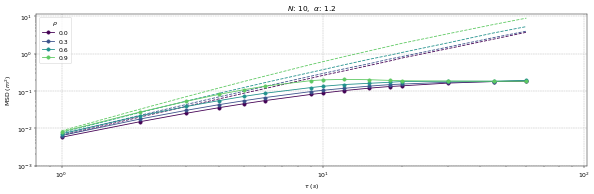

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#10_alpha#1.6.png


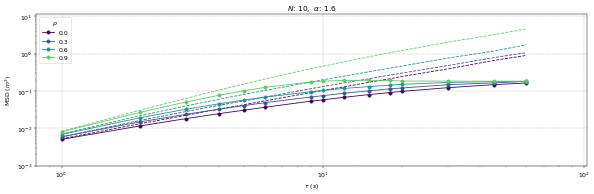

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#10_alpha#2.0.png


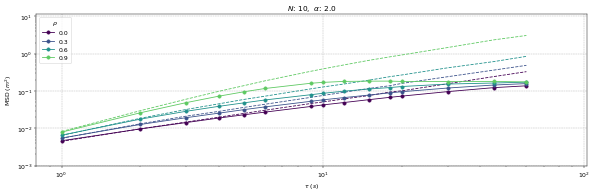

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#10_alpha#1.4.png


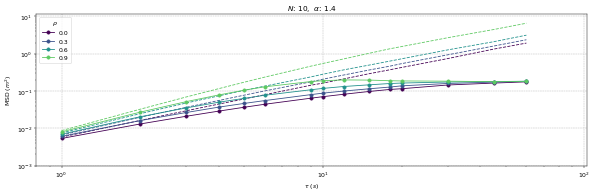

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#10_alpha#1.8.png


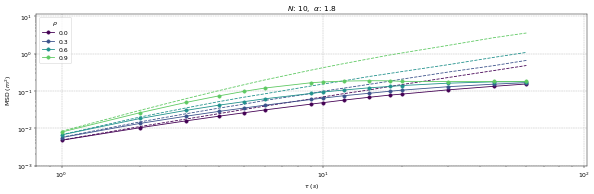

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#20_alpha#1.2.png


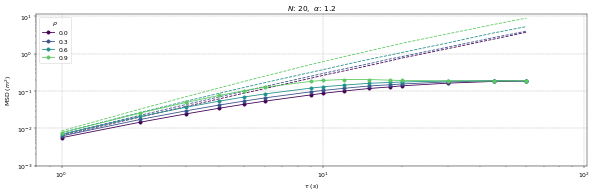

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#20_alpha#1.6.png


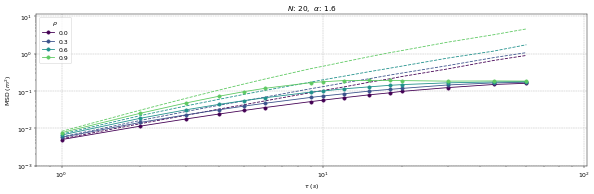

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#20_alpha#2.0.png


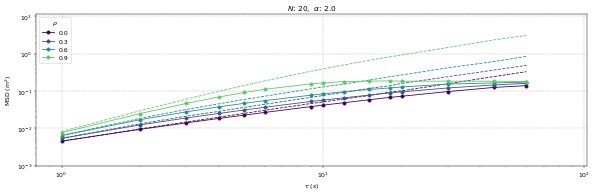

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#20_alpha#1.4.png


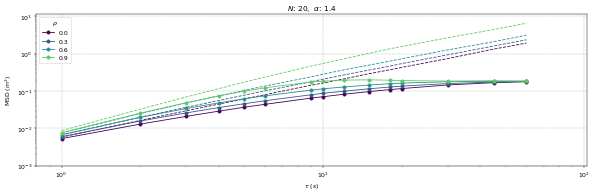

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#20_alpha#1.8.png


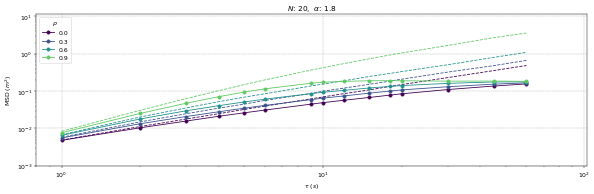

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#50_alpha#1.2.png


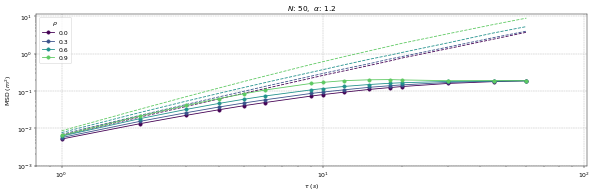

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#50_alpha#1.6.png


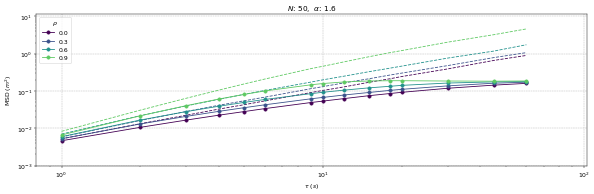

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#50_alpha#2.0.png


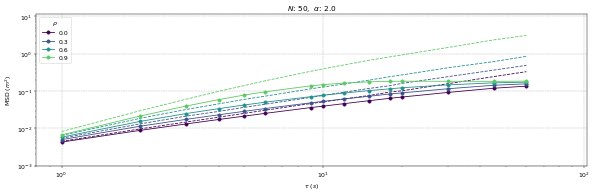

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#50_alpha#1.4.png


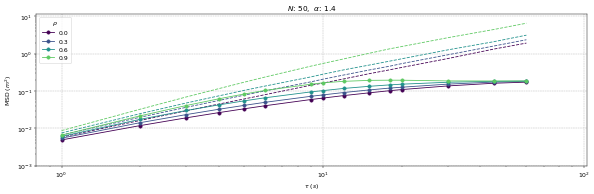

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#50_alpha#1.8.png


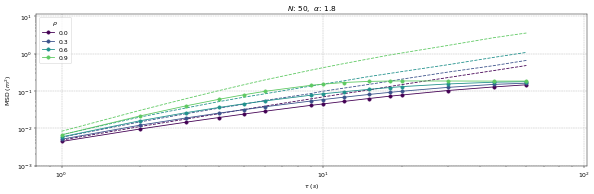

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#100_alpha#1.2.png


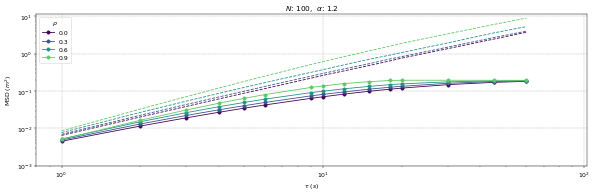

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#100_alpha#1.6.png


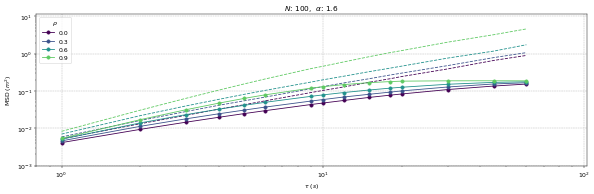

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#100_alpha#2.0.png


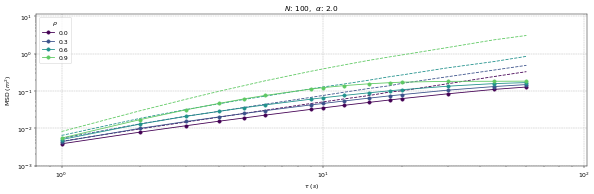

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#100_alpha#1.4.png


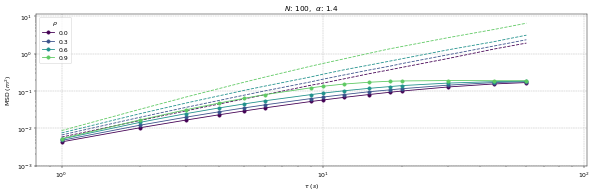

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_alpha/randomAngle_num_robots#100_alpha#1.8.png


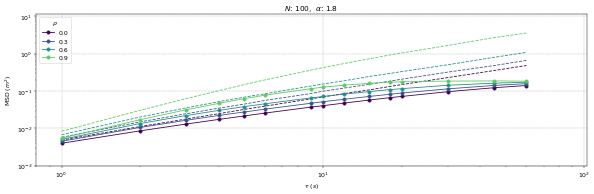

In [13]:
storeFolder = os.path.join(main_folder, 'Plots/3.randomAngle/MSD/fixed_alpha')
plot_MSD(randomAngle_dict, baseline_dict, saveFig=True, figName='randomAngle_', storeFolder=storeFolder)

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#10_alpha#1.2.png


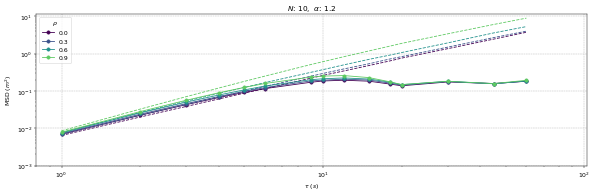

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#10_alpha#1.6.png


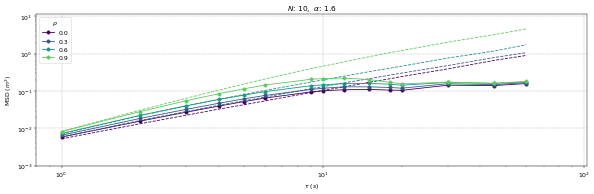

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#10_alpha#2.0.png


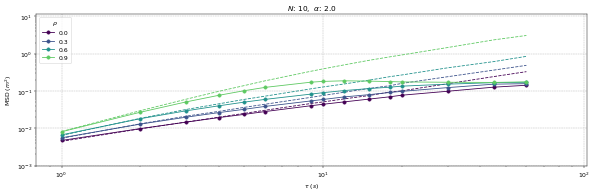

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#10_alpha#1.4.png


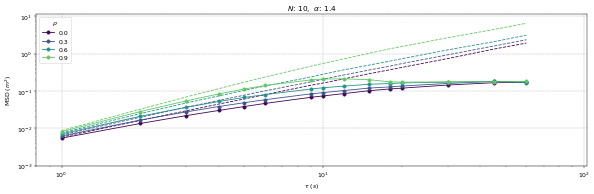

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#10_alpha#1.8.png


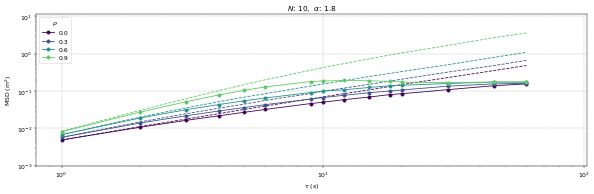

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#20_alpha#1.2.png


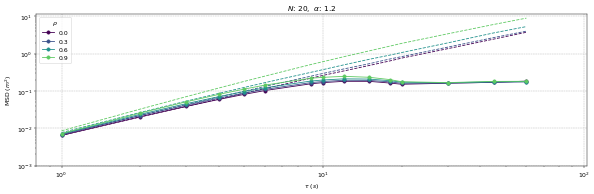

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#20_alpha#1.6.png


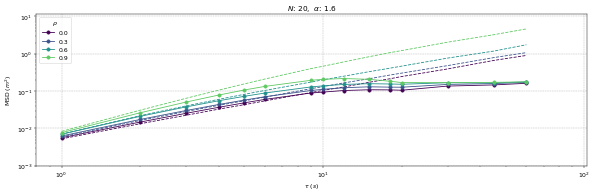

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#20_alpha#2.0.png


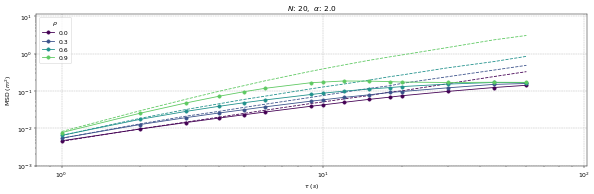

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#20_alpha#1.4.png


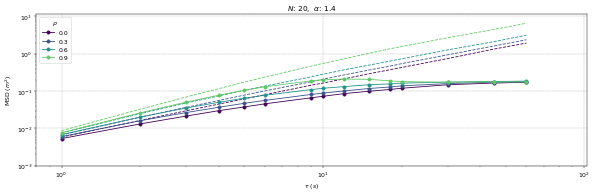

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#20_alpha#1.8.png


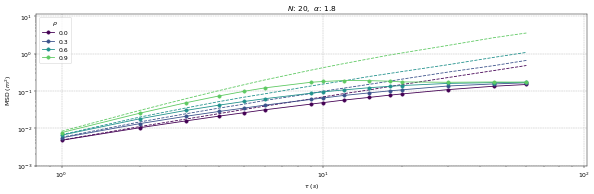

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#50_alpha#1.2.png


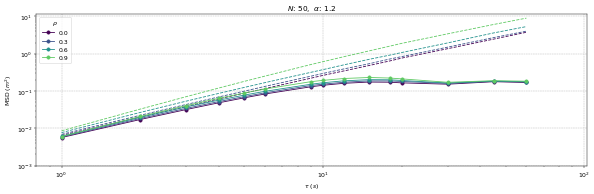

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#50_alpha#1.6.png


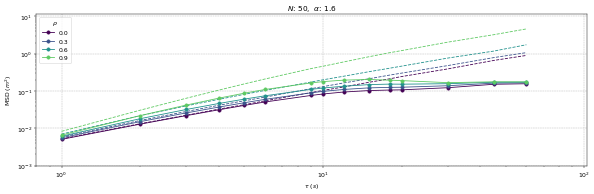

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#50_alpha#2.0.png


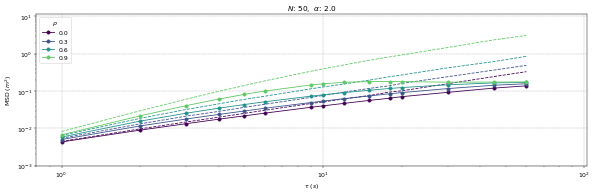

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#50_alpha#1.4.png


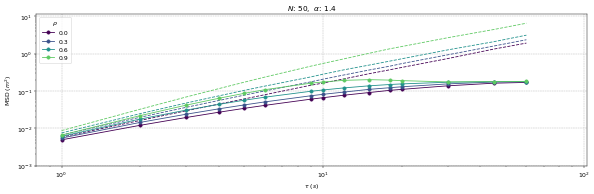

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#50_alpha#1.8.png


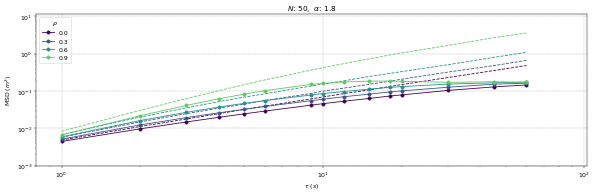

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#100_alpha#1.2.png


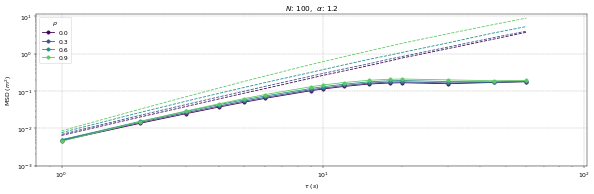

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#100_alpha#1.6.png


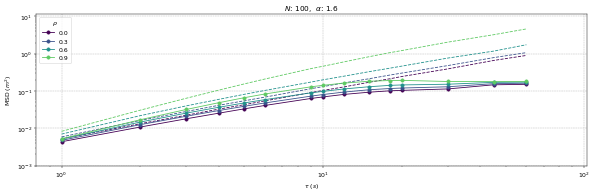

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#100_alpha#2.0.png


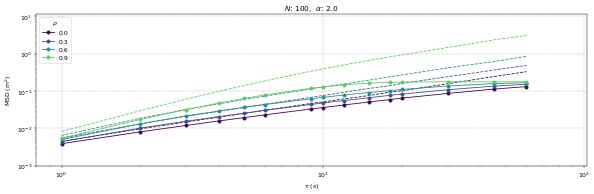

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#100_alpha#1.4.png


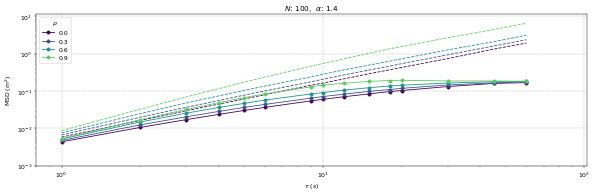

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_alpha/bouncingAngle_num_robots#100_alpha#1.8.png


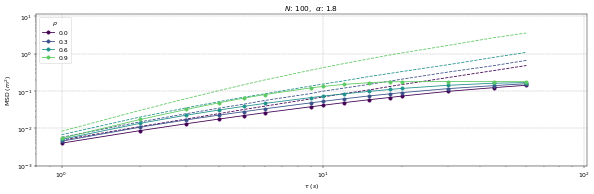

In [14]:
storeFolder = os.path.join(main_folder, 'Plots/2.bouncingAngle/MSD/fixed_alpha')
plot_MSD(bouncingAngle_dict, baseline_dict, saveFig=True, figName='bouncingAngle_', storeFolder=storeFolder)

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#10_alpha#1.2.png


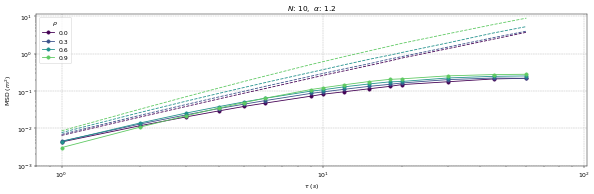

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#10_alpha#1.6.png


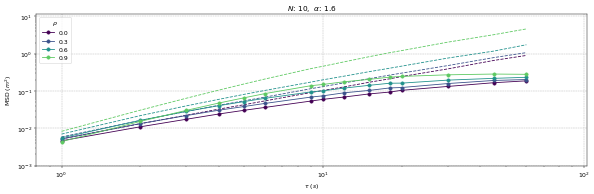

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#10_alpha#2.0.png


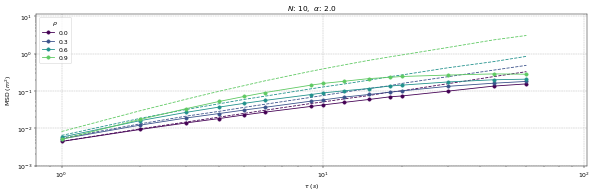

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#10_alpha#1.4.png


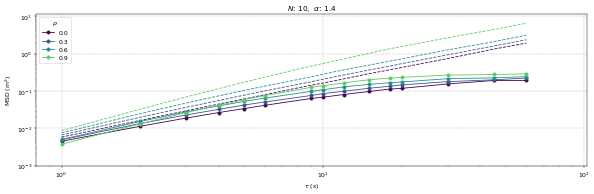

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#10_alpha#1.8.png


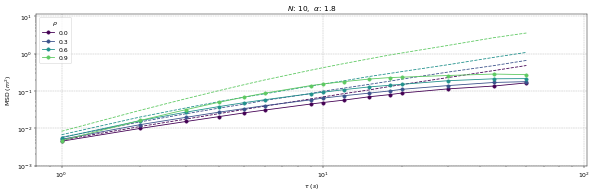

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#20_alpha#1.2.png


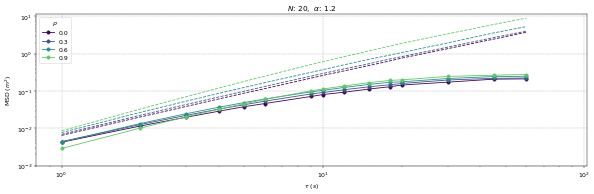

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#20_alpha#1.6.png


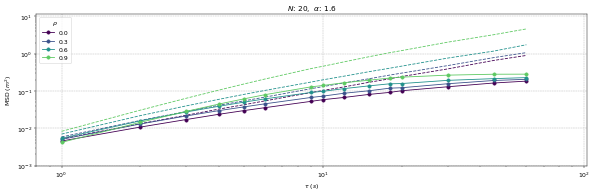

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#20_alpha#2.0.png


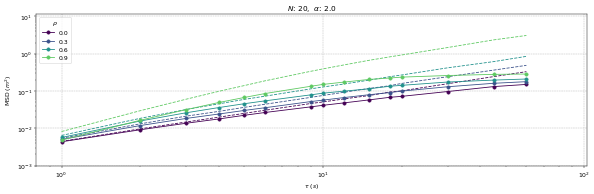

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#20_alpha#1.4.png


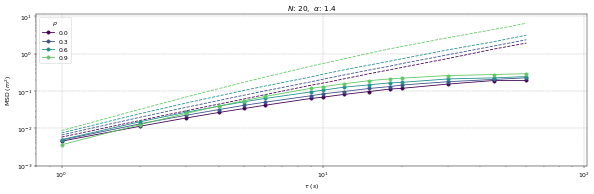

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#20_alpha#1.8.png


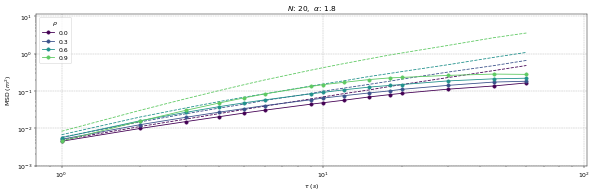

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#50_alpha#1.2.png


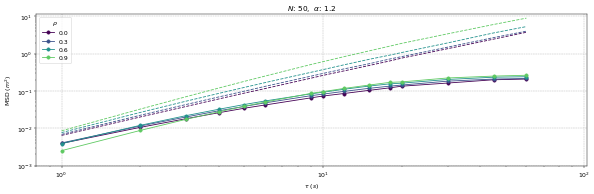

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#50_alpha#1.6.png


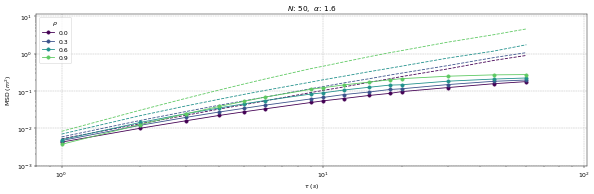

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#50_alpha#2.0.png


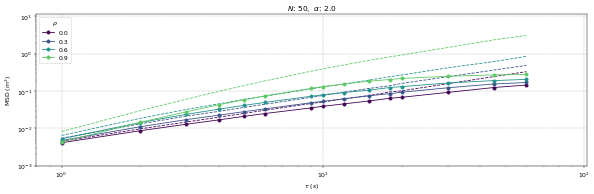

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#50_alpha#1.4.png


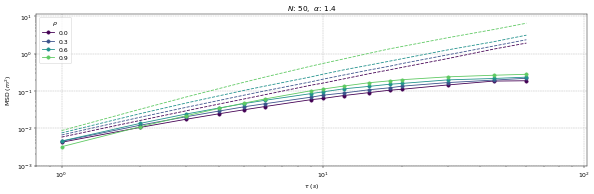

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#50_alpha#1.8.png


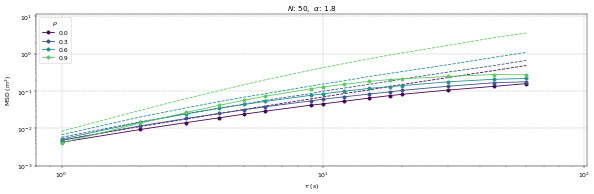

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#100_alpha#1.2.png


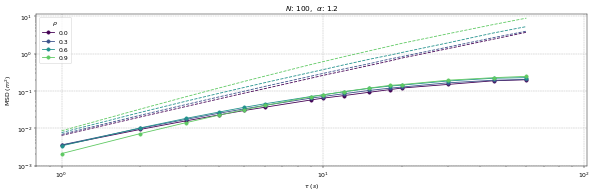

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#100_alpha#1.6.png


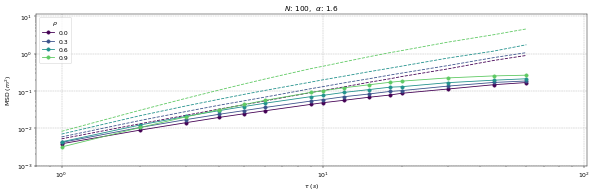

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#100_alpha#2.0.png


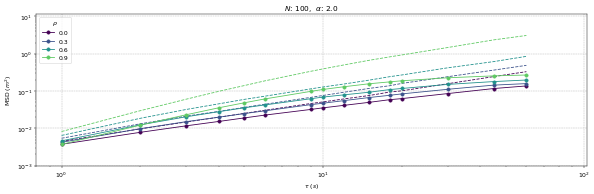

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#100_alpha#1.4.png


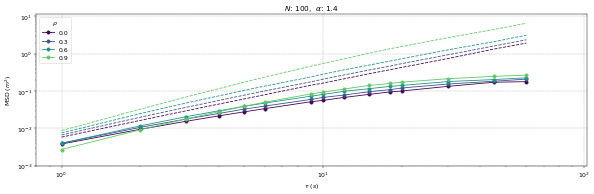

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_alpha/simpleExperiment_num_robots#100_alpha#1.8.png


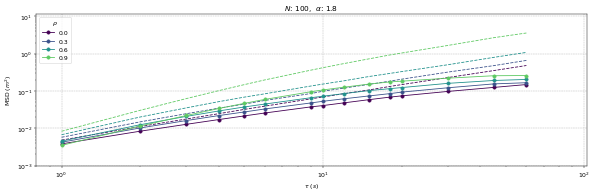

In [15]:
storeFolder = os.path.join(main_folder, 'Plots/1.simpleExperiment/MSD/fixed_alpha')
plot_MSD(simpleExperiment_dict, baseline_dict, saveFig=True, figName='simpleExperiment_', storeFolder=storeFolder)

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#10_alpha#1.2.png


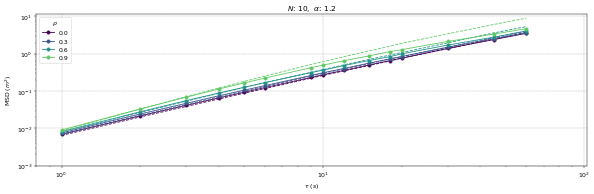

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#10_alpha#1.6.png


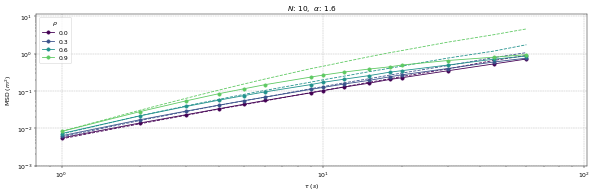

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#10_alpha#2.0.png


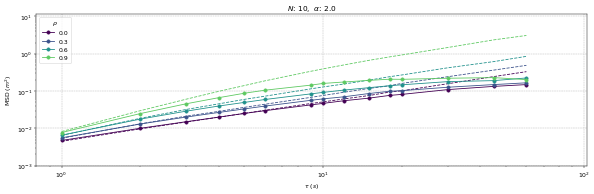

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#10_alpha#1.4.png


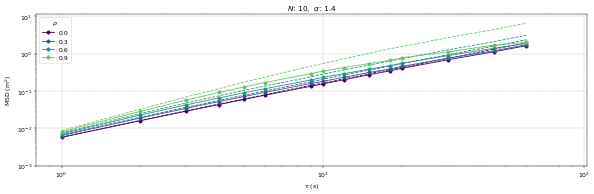

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#10_alpha#1.8.png


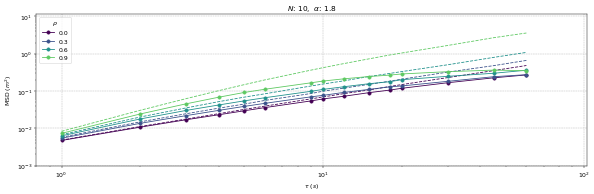

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#20_alpha#1.2.png


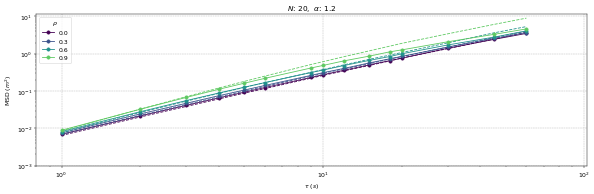

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#20_alpha#1.6.png


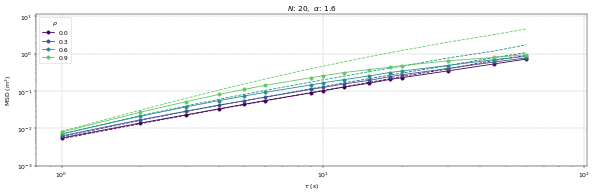

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#20_alpha#2.0.png


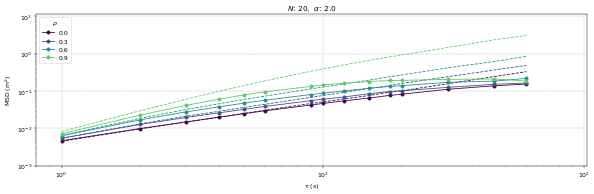

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#20_alpha#1.4.png


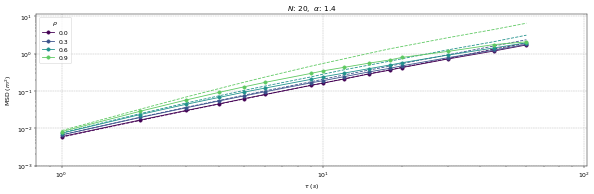

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#20_alpha#1.8.png


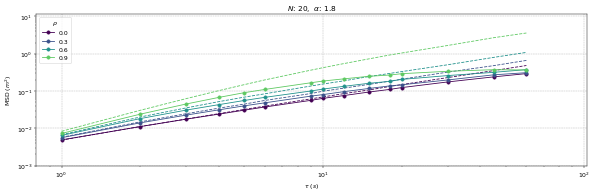

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#50_alpha#1.2.png


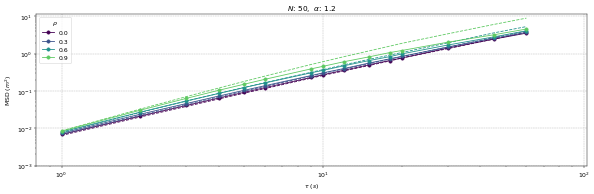

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#50_alpha#1.6.png


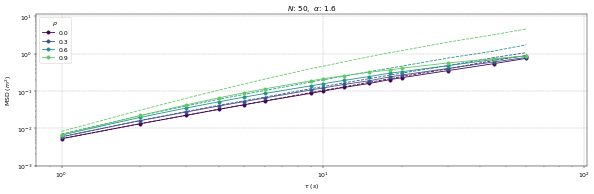

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#50_alpha#2.0.png


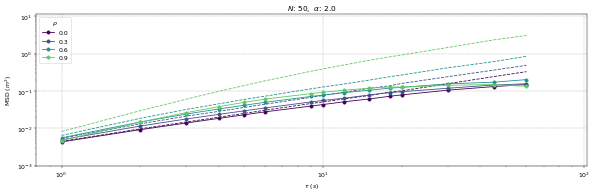

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#50_alpha#1.4.png


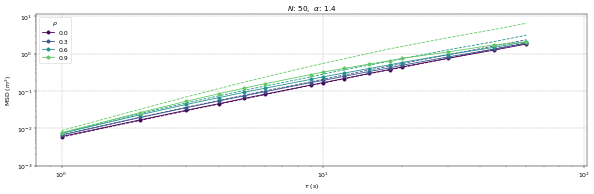

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#50_alpha#1.8.png


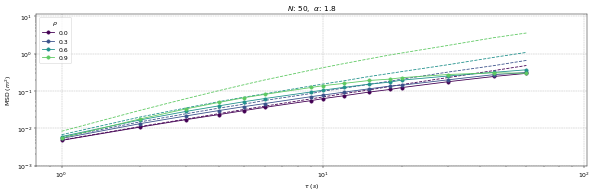

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#100_alpha#1.2.png


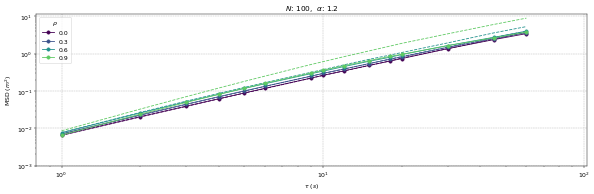

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#100_alpha#1.6.png


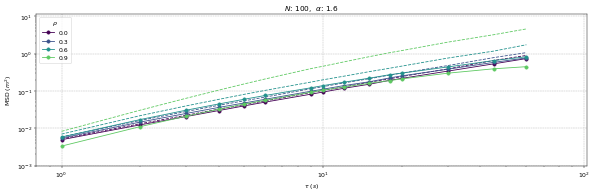

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#100_alpha#2.0.png


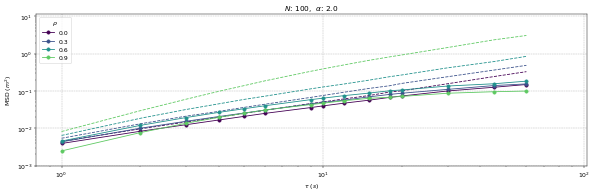

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#100_alpha#1.4.png


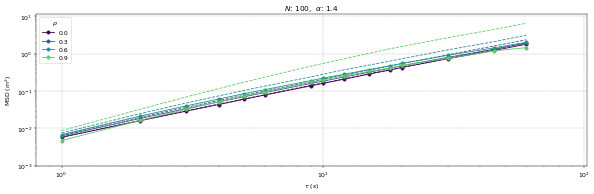

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_alpha/openSpace_num_robots#100_alpha#1.8.png


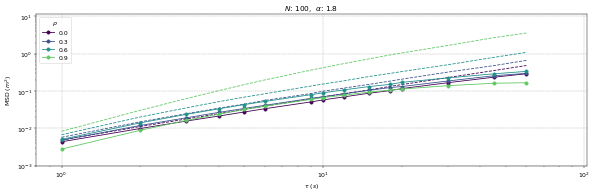

In [16]:
storeFolder = os.path.join(main_folder, 'Plots/4.openSpace/MSD/fixed_alpha')
plot_MSD(biasExperiment_dict, baseline_dict, saveFig=True, figName='openSpace_', storeFolder=storeFolder)

In [17]:
# simpleExperiment_folder

In [18]:
real_folder = 'results/ALL/pos_pkl/Real'
real_dict = evaluate_MSD(main_folder, real_folder, real_exp=True)

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/pos_pkl/Real
	fileName: robots#10_alpha#2.0_rho#0.0_real_pos.npy
	num_robots: 10, alpha: 2.0, rho: 0.0
	np_position.shape: (181, 100, 2)
	fileName: robots#10_alpha#2.0_rho#0.9_real_pos.npy
	num_robots: 10, alpha: 2.0, rho: 0.9
	np_position.shape: (181, 200, 2)
	fileName: robots#20_alpha#2.0_rho#0.0_real_pos.npy
	num_robots: 20, alpha: 2.0, rho: 0.0
	np_position.shape: (181, 300, 2)
	fileName: robots#20_alpha#2.0_rho#0.9_real_pos.npy
	num_robots: 20, alpha: 2.0, rho: 0.9
	np_position.shape: (181, 200, 2)


In [19]:
# real_dict.values()

In [20]:
# colors = ['red','blue','darkgreen','crimson','turquoise', 'khaki','navy', 'orangered', 'sienna']
Ncolors = 2
colormap = plt.cm.viridis  # LinearSegmentedColormap
Ncolors = min(colormap.N, Ncolors)
mapcolors = [colormap(int(x * colormap.N / (Ncolors-1))) for x in range(Ncolors)]

In [21]:
# plot_MSD(real_dict, baseline_dict, saveFig=True, figName='realExperiment_')

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/5.Real/MSD/fixed_alpha/realExperiment_num_robots#10_alpha#2.0.png


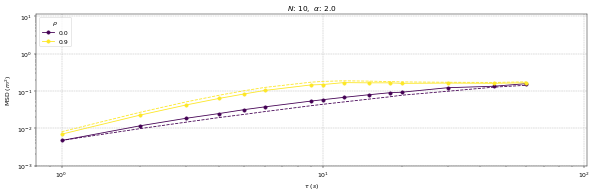

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/5.Real/MSD/fixed_alpha/realExperiment_num_robots#20_alpha#2.0.png


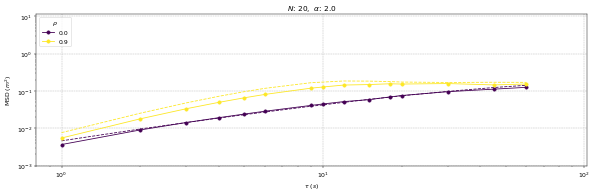

In [22]:
storeFolder = os.path.join(main_folder, 'Plots/5.Real/MSD/fixed_alpha')
plot_MSD(real_dict, bouncingAngle_dict, saveFig=True, figName='realExperiment_', real_comparison=True, storeFolder=storeFolder)

### Fixed rho

In [23]:
def evaluate_MSD_fixed_rho(main_folder, folder_experiments, real_exp = False):
    msd_dict = {}
    windows = np.array([1, 2, 3, 4, 5, 6, 9, 10, 12, 15, 18, 20, 30, 45, 60])
    
    for dirName, subdirList, fileList in os.walk(os.path.join(main_folder, folder_experiments)):
        print(colored("DirName:", 'blue'), dirName)
        num_robots = -1
        alpha = -1
        rho = -1
        for fileName in natsorted(fileList):
            if 'real' in fileName:
                exp_type = 'real'
                if real_exp == False:
                    continue
            else:
                exp_type = 'simulated'
                if real_exp == True:
                    continue

            print(colored("\tfileName:", 'blue'), fileName)
            elements = fileName.split('_')
            for e in elements:
                if e.startswith('robots'):
                    num_robots = int(e.split('#')[1])
                if e.startswith('alpha'):
                    alpha = e.split('#')[1]
                if e.startswith('rho'):
                    rho = e.split('#')[1]

            if num_robots == -1:
                print('Error!!! num_robots not a right value')
                exit(-1)

            if alpha == -1:
                print('Error!!! num_robots not a right value')
                exit(-1)

            if rho == -1:
                print('Error!!! num_robots not a right value')
                exit(-1)

            if num_robots not in msd_dict:
                msd_dict[num_robots] = {}
            if rho not in msd_dict[num_robots]:
                msd_dict[num_robots][rho] = {}

            print('\tnum_robots: {}, alpha: {}, rho: {}'.format(num_robots, alpha, rho))

            np_position = np.load(os.path.join(main_folder, folder_experiments, fileName))

            print('\tnp_position.shape:', np_position.shape)

            msd = np.array([])
#             print(f"windows:{windows}")
            for window in windows:
#                 print(f"window:{window}")
                msd_matrix = np.array([])
#                 print(f"Time:{np_position.shape[0]}")
                for f in range(window, np_position.shape[0], window):
#                     print(f"f:{f}")
        #             print('tf: {}, ti: {}'.format(f, f - window))
                    tf = np_position[f]
                    ti = np_position[f - window]
    #                 print('tf.shape:', tf.shape)
                    sq_distance = np.sum((tf - ti) ** 2, axis=1)

                    msd_matrix = np.row_stack([msd_matrix, sq_distance]) if msd_matrix.size else sq_distance
                msd = np.append(msd, np.mean(msd_matrix))


            msd_dict[num_robots][rho][alpha] = msd
            
    return msd_dict

In [24]:
def plot_MSD_fixed_rho(msd_dict, baseline_msd_dict, saveFig=False, figName='', real_comparison=False, storeFolder=None):
    for n_rob in msd_dict:
        for rho in msd_dict[n_rob]:
            fig, ax = plt.subplots()
            ax.set_yscale('log')
            ax.set_xscale('log')
            ax.grid(True,linestyle='--',color='0.7')
            
            x_axis = windows
#             plt.xticks(ticks=x_axis, labels=windows)
            
            plt.xlabel(r'$\tau$ $(s)$')
            plt.ylabel(r'MSD $(m^2)$')
            
    #         x_axis = np.arange(windows.size)

            for i,alpha in enumerate(msd_dict[n_rob][rho]):
                y_axis = msd_dict[n_rob][rho][alpha]
                ax.plot(x_axis, y_axis, marker='o', label=alpha, color=mapcolors[i])
                
#                 if a != '1.4' and a != '1.8':
                if real_comparison == False:
                    y_base_axis = baseline_msd_dict[1][rho][alpha]
                else:
                    y_base_axis = baseline_msd_dict[n_rob][rho][alpha]
                ax.plot(x_axis, y_base_axis, linestyle='dashed', color=mapcolors[i])

            
            
            
            ax.set_xlim([.8, 102])
            ax.set_ylim([0.001, 12])
            
            plt.title(r'$N$: {},  $\rho$: {}'.format(n_rob, rho))

            plt.legend(title=r"$\alpha$",loc=2)
            plt.tight_layout()
            
            
            if saveFig:
                try:
                    os.makedirs(storeFolder)
                except OSError as e:
                    if e.errno != errno.EEXIST:
                        raise
                fig_path = os.path.join(storeFolder, figName+'num_robots#{}_rho#{}.png'.format(n_rob, rho))
                plt.savefig(fig_path)
                print(f"Saving figure: {fig_path}")
            plt.show()

In [25]:
baseline_dict_fixed_rho = evaluate_MSD_fixed_rho(main_folder, baseline_folder)
simpleExperiment_dict_fixed_rho = evaluate_MSD_fixed_rho(main_folder, simpleExperiment_folder)
biasExperiment_dict_fixed_rho = evaluate_MSD_fixed_rho(main_folder, biasExperiment_folder)
randomAngle_dict_fixed_rho = evaluate_MSD_fixed_rho(main_folder, randomAngle_folder)
bouncingAngle_dict_fixed_rho = evaluate_MSD_fixed_rho(main_folder, bouncingAngle_folder)

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/pos_pkl/Simulated/baseline
	fileName: baseline_2021-10-13_robots#1_alpha#1.2_rho#0.0_baseline_1800simulated_pos.npy
	num_robots: 1, alpha: 1.2, rho: 0.0
	np_position.shape: (181, 500, 2)
	fileName: baseline_2021-10-13_robots#1_alpha#1.2_rho#0.3_baseline_1800simulated_pos.npy
	num_robots: 1, alpha: 1.2, rho: 0.3
	np_position.shape: (181, 500, 2)
	fileName: baseline_2021-10-13_robots#1_alpha#1.2_rho#0.6_baseline_1800simulated_pos.npy
	num_robots: 1, alpha: 1.2, rho: 0.6
	np_position.shape: (181, 500, 2)
	fileName: baseline_2021-10-13_robots#1_alpha#1.2_rho#0.9_baseline_1800simulated_pos.npy
	num_robots: 1, alpha: 1.2, rho: 0.9
	np_position.shape: (181, 500, 2)
	fileName: baseline_2021-10-13_robots#1_alpha#1.6_rho#0.0_baseline_1800simulated_pos.npy
	num_robots: 1, alpha: 1.6, rho: 0.0
	np_position.shape: (181, 500, 2)
	fileName: baseline_2021-10-13_robots#1_alpha#1.6_rho#0.3_baseline_1800simulated_pos.npy
	num_robots: 1, 

	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.2_rho#0.9_1800simulated_pos.npy
	num_robots: 50, alpha: 1.2, rho: 0.9
	np_position.shape: (181, 5000, 2)
	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.6_rho#0.0_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.0
	np_position.shape: (181, 5000, 2)
	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.6_rho#0.3_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.3
	np_position.shape: (181, 5000, 2)
	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.6_rho#0.6_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.6
	np_position.shape: (181, 5000, 2)
	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#1.6_rho#0.9_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.9
	np_position.shape: (181, 5000, 2)
	fileName: simple_experiment_100_runs_2020-06-03_robots#50_alpha#2.0_rho#0.0_1800simulated_pos.npy
	num_robots: 50, alpha: 2.0, rho: 0.0
	np

	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.3
	np_position.shape: (181, 10000, 2)
	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.6_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.6
	np_position.shape: (181, 10000, 2)
	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.9_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.9
	np_position.shape: (181, 10000, 2)
	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.8_rho#0.0_1800simulated_pos.npy
	num_robots: 100, alpha: 1.8, rho: 0.0
	np_position.shape: (181, 10000, 2)
	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.8_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 1.8, rho: 0.3
	np_position.shape: (181, 10000, 2)
	fileName: simple_experiment_100_runs_2021-09-22_robots#100_alpha#1.8_rho#0.6_1800simulated_pos.npy
	num_robots: 100, alpha: 

	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.2_rho#0.6_1800simulated_pos.npy
	num_robots: 100, alpha: 1.2, rho: 0.6
	np_position.shape: (181, 10000, 2)
	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.2_rho#0.9_1800simulated_pos.npy
	num_robots: 100, alpha: 1.2, rho: 0.9
	np_position.shape: (181, 10000, 2)
	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.6_rho#0.0_1800simulated_pos.npy
	num_robots: 100, alpha: 1.6, rho: 0.0
	np_position.shape: (181, 10000, 2)
	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.6_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 1.6, rho: 0.3
	np_position.shape: (181, 10000, 2)
	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.6_rho#0.6_1800simulated_pos.npy
	num_robots: 100, alpha: 1.6, rho: 0.6
	np_position.shape: (181, 10000, 2)
	fileName: bias_experiment_100_runs_2020-07-09_robots#100_alpha#1.6_rho#0.9_1800simulated_pos.npy
	num_robots: 100, alpha: 1.6, rho: 0.

	fileName: random_angle_100_runs_2020-07-03_robots#10_alpha#2.0_rho#0.6_1800simulated_pos.npy
	num_robots: 10, alpha: 2.0, rho: 0.6
	np_position.shape: (181, 1000, 2)
	fileName: random_angle_100_runs_2020-07-03_robots#10_alpha#2.0_rho#0.9_1800simulated_pos.npy
	num_robots: 10, alpha: 2.0, rho: 0.9
	np_position.shape: (181, 1000, 2)
	fileName: random_angle_100_runs_2020-07-03_robots#20_alpha#1.2_rho#0.0_1800simulated_pos.npy
	num_robots: 20, alpha: 1.2, rho: 0.0
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2020-07-03_robots#20_alpha#1.2_rho#0.3_1800simulated_pos.npy
	num_robots: 20, alpha: 1.2, rho: 0.3
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2020-07-03_robots#20_alpha#1.2_rho#0.6_1800simulated_pos.npy
	num_robots: 20, alpha: 1.2, rho: 0.6
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2020-07-03_robots#20_alpha#1.2_rho#0.9_1800simulated_pos.npy
	num_robots: 20, alpha: 1.2, rho: 0.9
	np_position.shape: (181, 2000, 2

	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.4_rho#0.3_1800simulated_pos.npy
	num_robots: 20, alpha: 1.4, rho: 0.3
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.4_rho#0.6_1800simulated_pos.npy
	num_robots: 20, alpha: 1.4, rho: 0.6
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.4_rho#0.9_1800simulated_pos.npy
	num_robots: 20, alpha: 1.4, rho: 0.9
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.8_rho#0.0_1800simulated_pos.npy
	num_robots: 20, alpha: 1.8, rho: 0.0
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.8_rho#0.3_1800simulated_pos.npy
	num_robots: 20, alpha: 1.8, rho: 0.3
	np_position.shape: (181, 2000, 2)
	fileName: random_angle_100_runs_2021-09-22_robots#20_alpha#1.8_rho#0.6_1800simulated_pos.npy
	num_robots: 20, alpha: 1.8, rho: 0.6
	np_position.shape: (181, 2000, 2

	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.2_rho#0.3_1800simulated_pos.npy
	num_robots: 50, alpha: 1.2, rho: 0.3
	np_position.shape: (181, 5000, 2)
	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.2_rho#0.6_1800simulated_pos.npy
	num_robots: 50, alpha: 1.2, rho: 0.6
	np_position.shape: (181, 5000, 2)
	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.2_rho#0.9_1800simulated_pos.npy
	num_robots: 50, alpha: 1.2, rho: 0.9
	np_position.shape: (181, 5000, 2)
	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.6_rho#0.0_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.0
	np_position.shape: (181, 5000, 2)
	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.6_rho#0.3_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.3
	np_position.shape: (181, 5000, 2)
	fileName: bouncing_angle_100_runs_2020-07-01_robots#50_alpha#1.6_rho#0.6_1800simulated_pos.npy
	num_robots: 50, alpha: 1.6, rho: 0.6
	np_position.shape: (

	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.0_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.0
	np_position.shape: (181, 2000, 2)
	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.3
	np_position.shape: (181, 2000, 2)
	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.6_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.6
	np_position.shape: (181, 2000, 2)
	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.4_rho#0.9_1800simulated_pos.npy
	num_robots: 100, alpha: 1.4, rho: 0.9
	np_position.shape: (181, 2000, 2)
	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.8_rho#0.0_1800simulated_pos.npy
	num_robots: 100, alpha: 1.8, rho: 0.0
	np_position.shape: (181, 2000, 2)
	fileName: bouncing_angle_100_runs_2021-09-22_robots#100_alpha#1.8_rho#0.3_1800simulated_pos.npy
	num_robots: 100, alpha: 1.8, rho: 0.3
	np_posit

In [26]:
# simpleExperiment_dict

In [27]:
# colors = ['red','blue','darkgreen','crimson','turquoise', 'khaki','navy', 'orangered', 'sienna']
Ncolors = 5
colormap = plt.cm.viridis  # LinearSegmentedColormap
Ncolors = min(colormap.N, Ncolors)
mapcolors = [colormap(int(x * colormap.N / Ncolors)) for x in range(Ncolors)]

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#10_rho#0.0.png


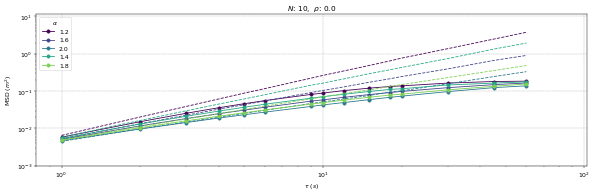

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#10_rho#0.3.png


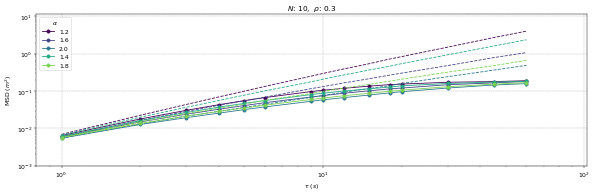

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#10_rho#0.6.png


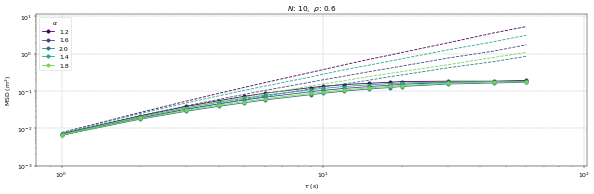

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#10_rho#0.9.png


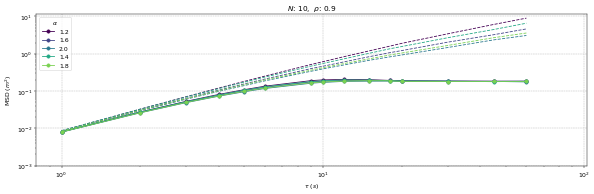

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#20_rho#0.0.png


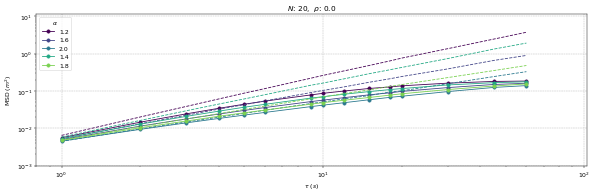

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#20_rho#0.3.png


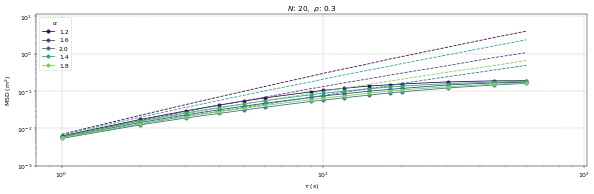

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#20_rho#0.6.png


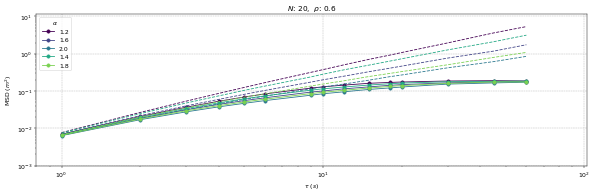

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#20_rho#0.9.png


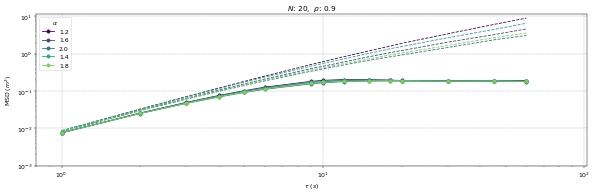

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#50_rho#0.0.png


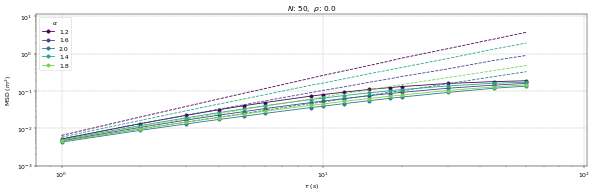

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#50_rho#0.3.png


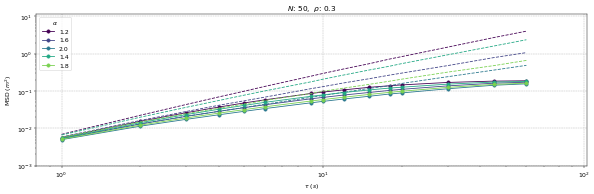

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#50_rho#0.6.png


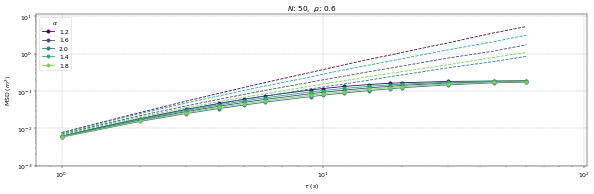

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#50_rho#0.9.png


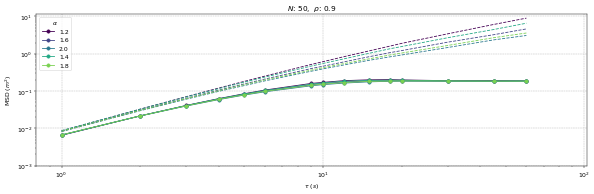

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#100_rho#0.0.png


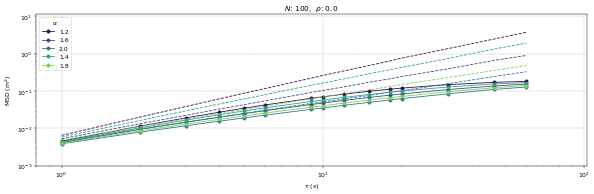

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#100_rho#0.3.png


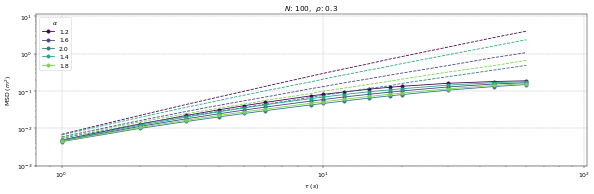

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#100_rho#0.6.png


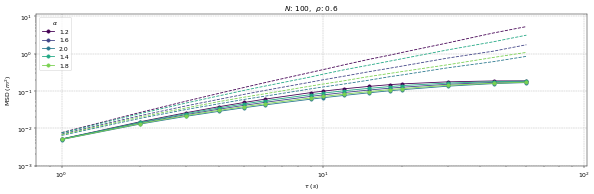

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/3.randomAngle/MSD/fixed_rho/randomAngle_num_robots#100_rho#0.9.png


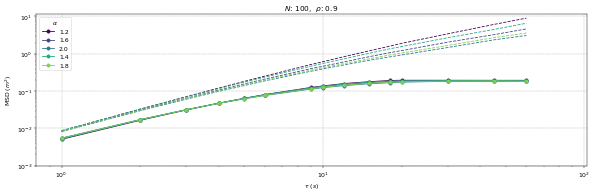

In [28]:
storeFolder = os.path.join(main_folder, 'Plots/3.randomAngle/MSD/fixed_rho')
plot_MSD_fixed_rho(randomAngle_dict_fixed_rho, baseline_dict_fixed_rho, saveFig=True, figName='randomAngle_', storeFolder=storeFolder)

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#10_rho#0.0.png


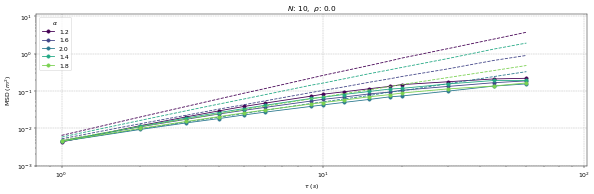

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#10_rho#0.3.png


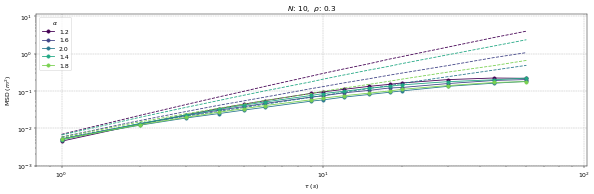

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#10_rho#0.6.png


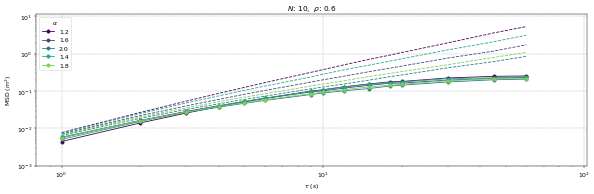

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#10_rho#0.9.png


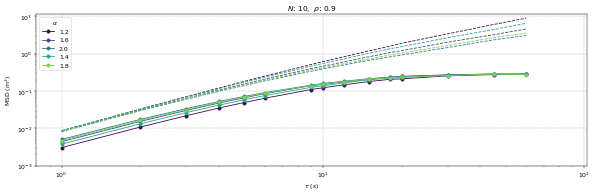

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#20_rho#0.0.png


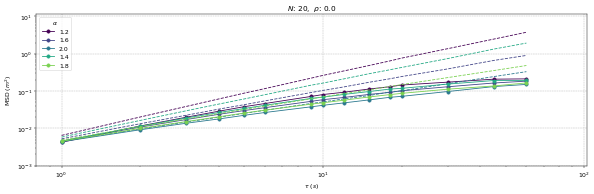

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#20_rho#0.3.png


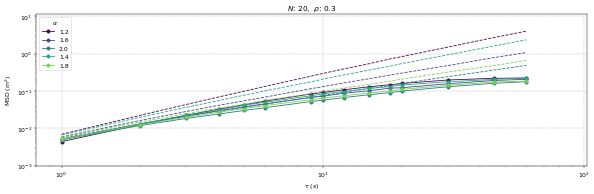

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#20_rho#0.6.png


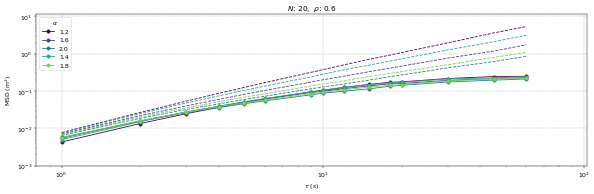

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#20_rho#0.9.png


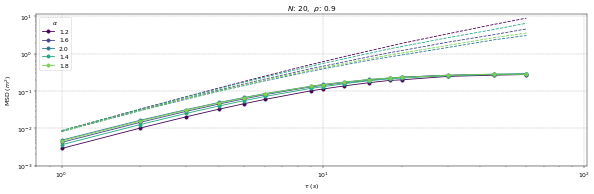

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#50_rho#0.0.png


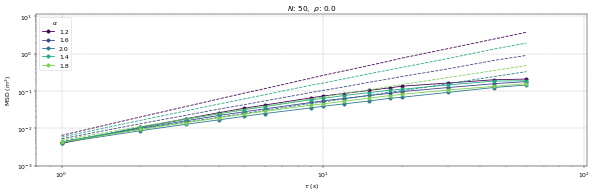

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#50_rho#0.3.png


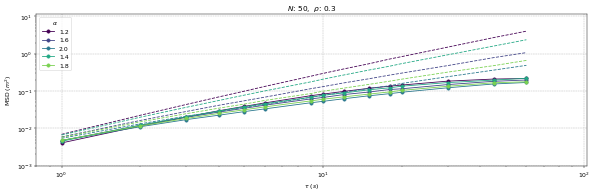

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#50_rho#0.6.png


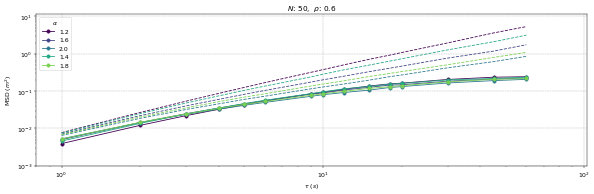

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#50_rho#0.9.png


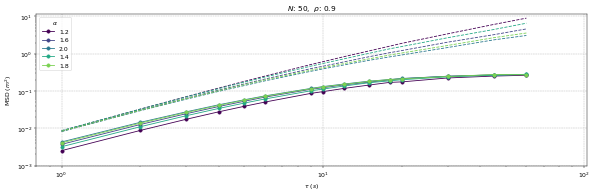

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#100_rho#0.0.png


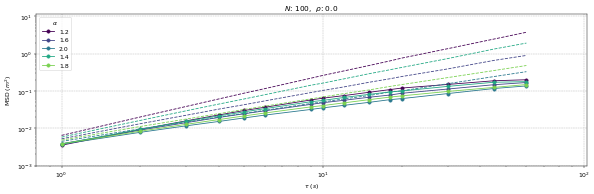

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#100_rho#0.3.png


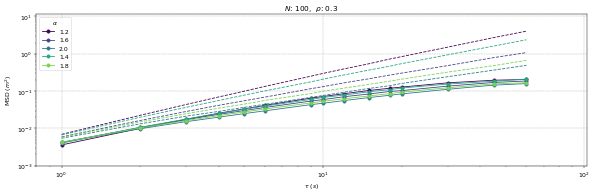

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#100_rho#0.6.png


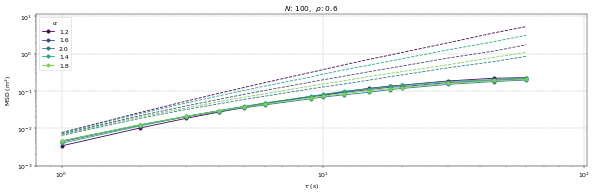

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/1.simpleExperiment/MSD/fixed_rho/simpleExperiment_num_robots#100_rho#0.9.png


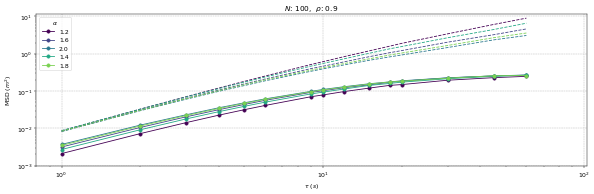

In [29]:
storeFolder = os.path.join(main_folder, 'Plots/1.simpleExperiment/MSD/fixed_rho')
plot_MSD_fixed_rho(simpleExperiment_dict_fixed_rho, baseline_dict_fixed_rho, saveFig=True, figName='simpleExperiment_', storeFolder=storeFolder)

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#10_rho#0.0.png


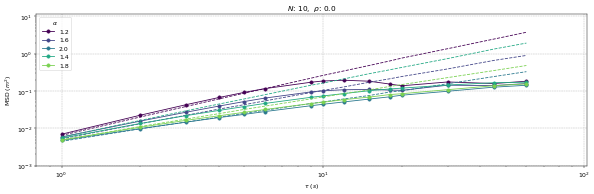

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#10_rho#0.3.png


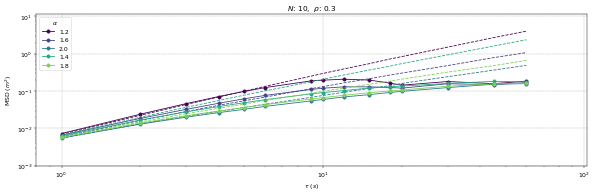

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#10_rho#0.6.png


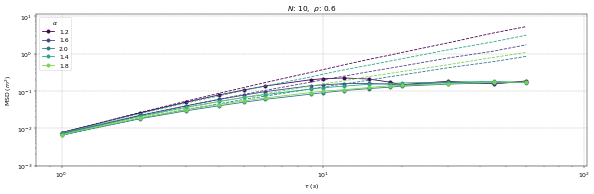

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#10_rho#0.9.png


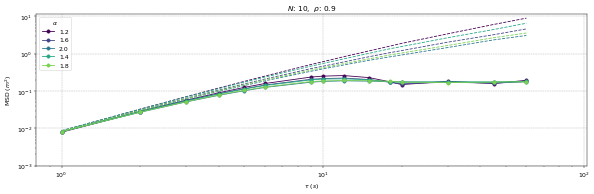

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#20_rho#0.0.png


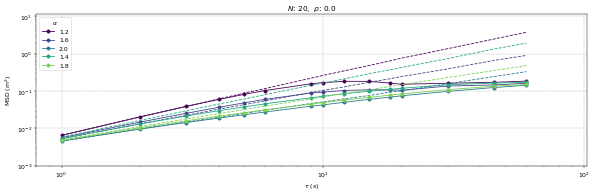

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#20_rho#0.3.png


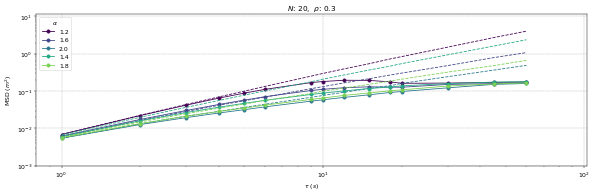

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#20_rho#0.6.png


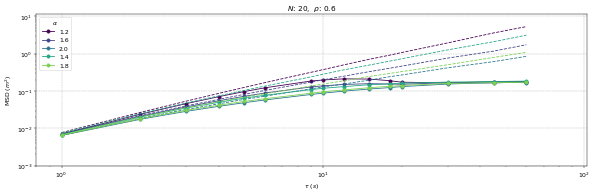

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#20_rho#0.9.png


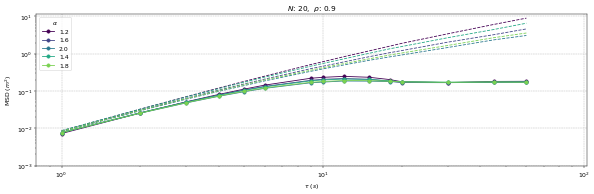

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#50_rho#0.0.png


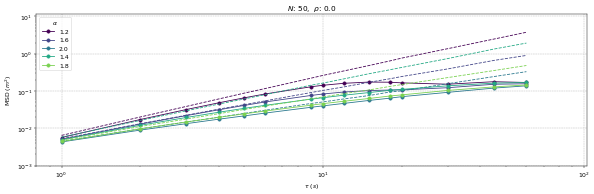

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#50_rho#0.3.png


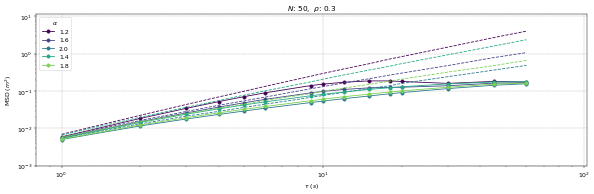

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#50_rho#0.6.png


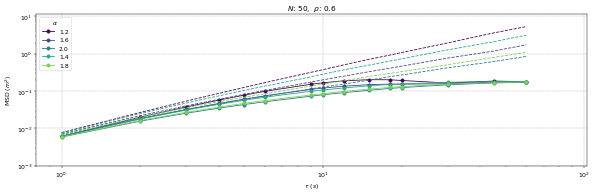

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#50_rho#0.9.png


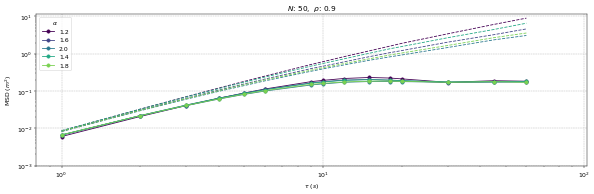

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#100_rho#0.0.png


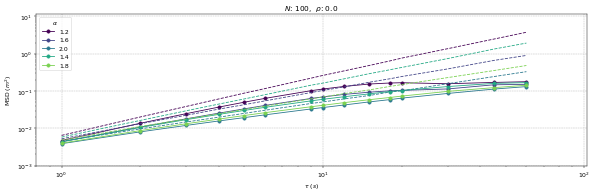

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#100_rho#0.3.png


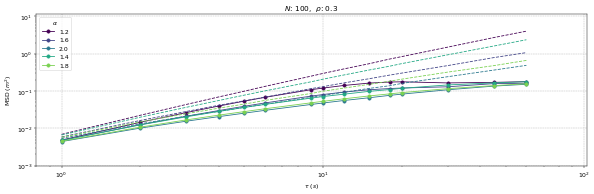

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#100_rho#0.6.png


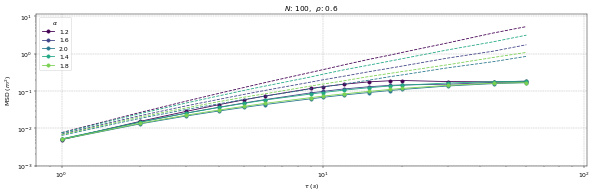

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/2.bouncingAngle/MSD/fixed_rho/bouncingAngle_num_robots#100_rho#0.9.png


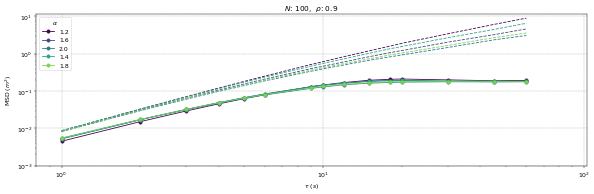

In [30]:
storeFolder = os.path.join(main_folder, 'Plots/2.bouncingAngle/MSD/fixed_rho')
plot_MSD_fixed_rho(bouncingAngle_dict_fixed_rho, baseline_dict_fixed_rho, saveFig=True, figName='bouncingAngle_', storeFolder=storeFolder)

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#10_rho#0.0.png


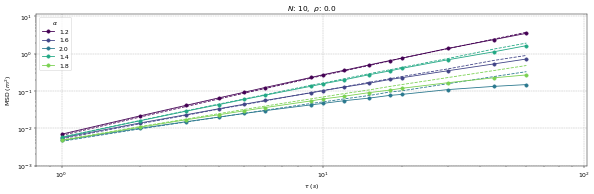

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#10_rho#0.3.png


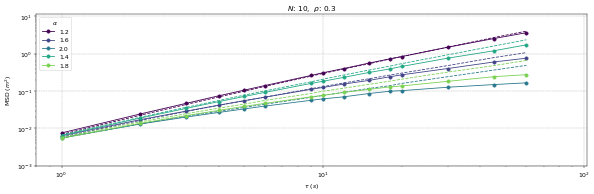

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#10_rho#0.6.png


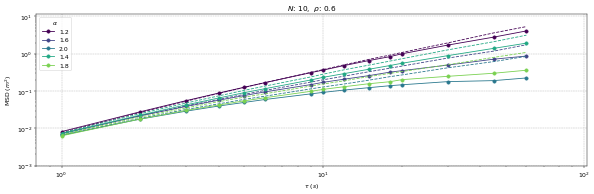

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#10_rho#0.9.png


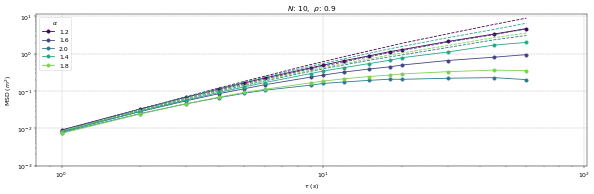

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#20_rho#0.0.png


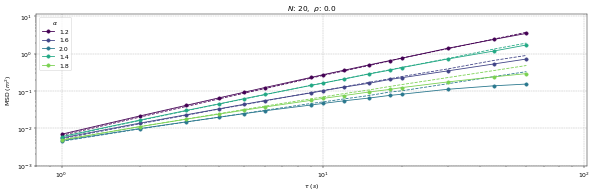

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#20_rho#0.3.png


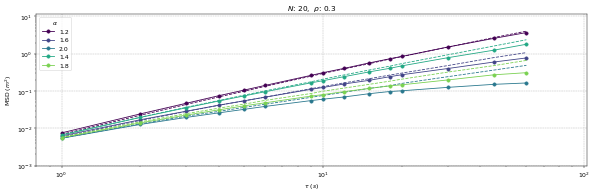

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#20_rho#0.6.png


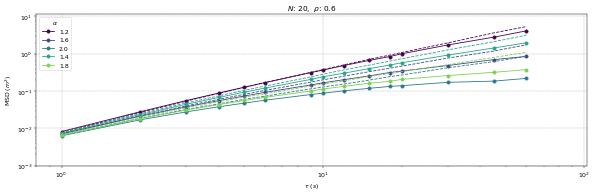

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#20_rho#0.9.png


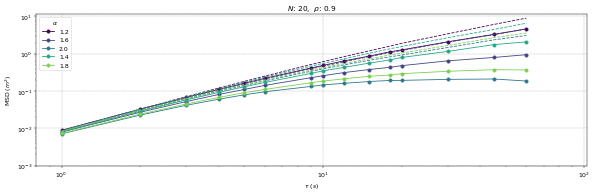

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#50_rho#0.0.png


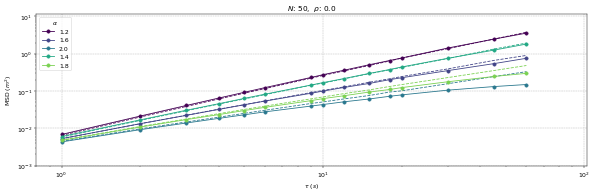

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#50_rho#0.3.png


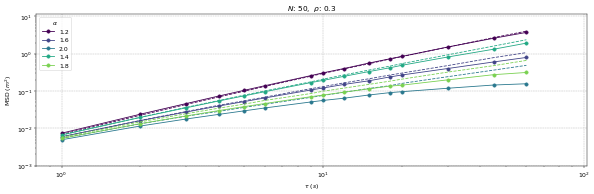

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#50_rho#0.6.png


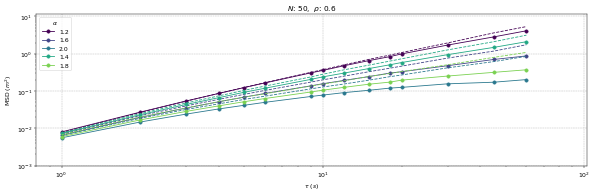

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#50_rho#0.9.png


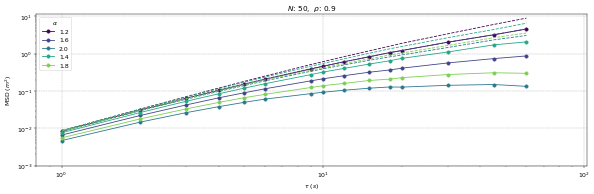

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#100_rho#0.0.png


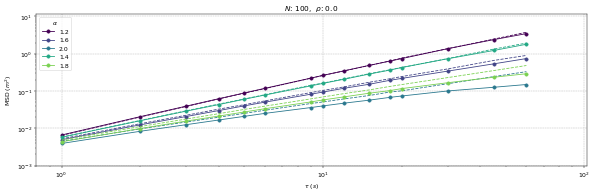

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#100_rho#0.3.png


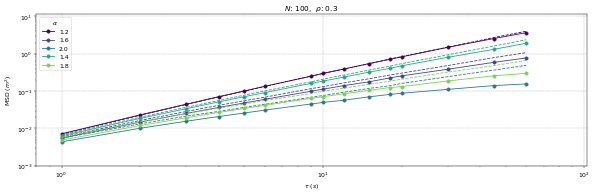

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#100_rho#0.6.png


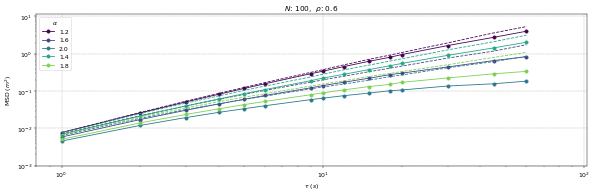

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/4.openSpace/MSD/fixed_rho/openSpace_num_robots#100_rho#0.9.png


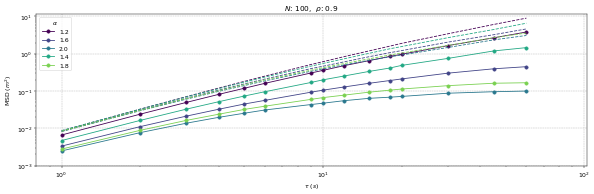

In [31]:
storeFolder = os.path.join(main_folder, 'Plots/4.openSpace/MSD/fixed_rho')
plot_MSD_fixed_rho(biasExperiment_dict_fixed_rho, baseline_dict_fixed_rho, saveFig=True, figName='openSpace_', storeFolder=storeFolder)

In [32]:
real_folder = 'results/ALL/pos_pkl/Real'
real_dict_fixed_rho = evaluate_MSD_fixed_rho(main_folder, real_folder, real_exp=True)

DirName: /home/luigi/Documents/ARGoS/argos-LMCRW-script/results/ALL/pos_pkl/Real
	fileName: robots#10_alpha#2.0_rho#0.0_real_pos.npy
	num_robots: 10, alpha: 2.0, rho: 0.0
	np_position.shape: (181, 100, 2)
	fileName: robots#10_alpha#2.0_rho#0.9_real_pos.npy
	num_robots: 10, alpha: 2.0, rho: 0.9
	np_position.shape: (181, 200, 2)
	fileName: robots#20_alpha#2.0_rho#0.0_real_pos.npy
	num_robots: 20, alpha: 2.0, rho: 0.0
	np_position.shape: (181, 300, 2)
	fileName: robots#20_alpha#2.0_rho#0.9_real_pos.npy
	num_robots: 20, alpha: 2.0, rho: 0.9
	np_position.shape: (181, 200, 2)


In [33]:
# colors = ['red','blue','darkgreen','crimson','turquoise', 'khaki','navy', 'orangered', 'sienna']
Ncolors = 2
colormap = plt.cm.viridis  # LinearSegmentedColormap
Ncolors = min(colormap.N, Ncolors)
mapcolors = [colormap(int(x * colormap.N / (Ncolors-1))) for x in range(Ncolors)]

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/5.Real/MSD/fixed_rho/realExperiment_num_robots#10_rho#0.0.png


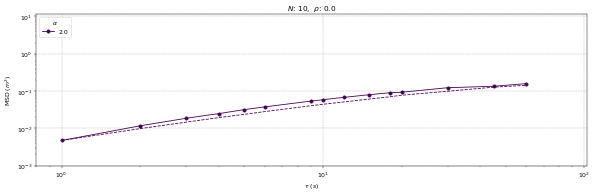

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/5.Real/MSD/fixed_rho/realExperiment_num_robots#10_rho#0.9.png


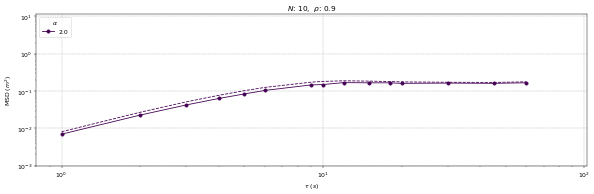

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/5.Real/MSD/fixed_rho/realExperiment_num_robots#20_rho#0.0.png


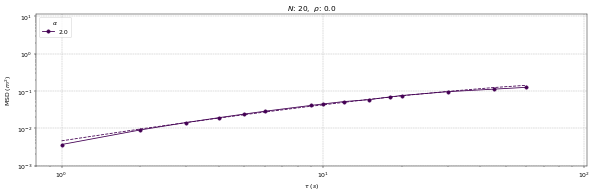

Saving figure: /home/luigi/Documents/ARGoS/argos-LMCRW-script/Plots/5.Real/MSD/fixed_rho/realExperiment_num_robots#20_rho#0.9.png


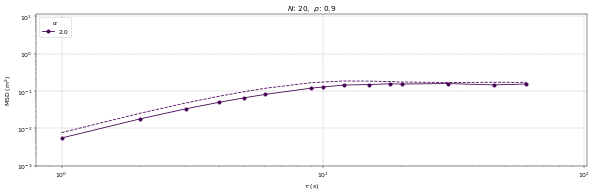

In [34]:
storeFolder = os.path.join(main_folder, 'Plots/5.Real/MSD/fixed_rho')
plot_MSD_fixed_rho(real_dict_fixed_rho, bouncingAngle_dict_fixed_rho, saveFig=True, figName='realExperiment_', real_comparison=True, storeFolder=storeFolder)